# Imports

In [1]:
import numpy as np
import pandas as pd
#import cv2 as cv
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import requests
import math
from PIL import Image
from io import BytesIO
from collections import Counter
from sklearn.model_selection import train_test_split


import wandb
from wandb.keras import WandbCallback

# Tensorflow imports

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
import tensorflow as tf
from tensorflow import keras
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} ) 
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, GaussianNoise
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical


# Check if GPU/CPU is connected

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17875324153732122321
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18140834485947038153
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4973462816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4941599644567088042
physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:26:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8545576352433101119
physical_device_desc: "device: XLA_GPU device"
]


# Dataset exploration

Total number of categories: 150
Total number of images in dataset: 10841


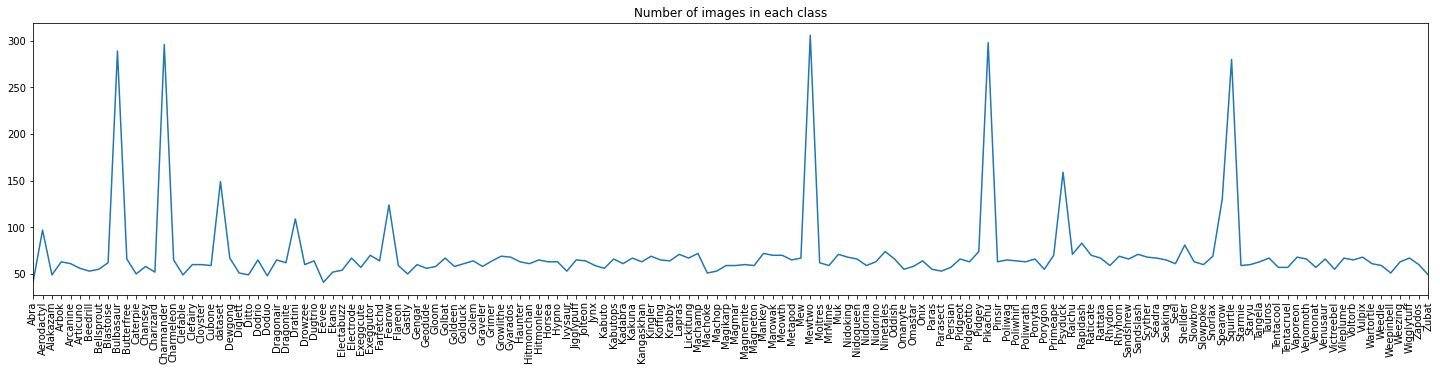

[('Mewtwo', 306), ('Pikachu', 298), ('Charmander', 296), ('Bulbasaur', 289), ('Squirtle', 280)]
['Mewtwo', 'Pikachu', 'Charmander', 'Bulbasaur', 'Squirtle']


In [4]:
# A little bit of data exploration
path = 'dataset/' # Path to directory which contains classes
classes = os.listdir(path) # List of all classes
print(f'Total number of categories: {len(classes)}')

# A dictionary which contains class and number of images in that class
counts = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(path, c)))
    
print(f'Total number of images in dataset: {sum(list(counts.values()))}')

# Number of images in each clsss plot
fig = plt.figure(figsize = (25, 5))
sns.lineplot(x = list(counts.keys()), y = list(counts.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

# Sort our "counts" dictionary and selecting 5 classes with most number of images
imbalanced = sorted(counts.items(), key = lambda x: x[1], reverse = True)[:5]
print(imbalanced)

# Taking only labels, it will come in handy in future
imbalanced = [i[0] for i in imbalanced]
print(imbalanced)

In [5]:
path = 'test_dataset/' # Path to directory which contains classes
classes = os.listdir(path) # List of all classes
counts = {}
img_paths = []
for c in classes:
    counts[c] = len(os.listdir(os.path.join(path, c)))
for c in classes:
    # We take only classes that we defined in 'imbalanced' list
    if c in imbalanced:
        dir_path = os.path.join("test_dataset/", c)
        label = imbalanced.index(c) # Our label is an index of class in 'imbalanced' list
        
        # Reading, resizing and adding image and label to lists
        for i in os.listdir(dir_path):
            img_paths.append((dir_path+"/"+i,c))

img_paths = pd.DataFrame(img_paths,columns=["path", "class"])
msk = np.random.rand(len(img_paths)) < 0.8
train = img_paths[msk]
test = img_paths[~msk]

In [6]:
train

,path,class
0,test_dataset/Bulbasaur/00000000.png,Bulbasaur
1,test_dataset/Bulbasaur/00000001.png,Bulbasaur
2,test_dataset/Bulbasaur/00000002.png,Bulbasaur
3,test_dataset/Bulbasaur/00000003.png,Bulbasaur
4,test_dataset/Bulbasaur/00000004.png,Bulbasaur
...,...,...
1461,test_dataset/Squirtle/e0e5b0b035e34d8d984bd844...,Squirtle
1463,test_dataset/Squirtle/e63006a99ba44ea986711830...,Squirtle
1464,test_dataset/Squirtle/eb8bc590c79b418194b8b41f...,Squirtle
1465,test_dataset/Squirtle/ed35cfd00fb94e99af1fae8b...,Squirtle


In [7]:
# Defining ImageDataGenerator Iinstance
datagen = ImageDataGenerator(rotation_range = 45, # Degree range for random rotations
                            zoom_range = 0.2, # Range for random zoom 
                            horizontal_flip = True, # Randomly flip inputs horizontally
                            width_shift_range = 0.15, # Range for horizontal shift 
                            height_shift_range = 0.15, # Range for vertical shift 
                            shear_range = 0.2
                            ) # Shear Intensity

train_generator = datagen.flow_from_dataframe(
    train,
    x_col="path",
    y_col="class",
    target_size=(96,96),
    batch_size=32,
    color_mode="rbg",
    classes=None,
    class_mode="categorical",
    save_to_dir="output",
    #save_prefix="test",
    follow_links=False,
    subset=None
)

test_generator = datagen.flow_from_dataframe(
    test,
    x_col="path",
    y_col="class",
    target_size=(96,96),
    batch_size=32,
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    save_prefix="test",
    follow_links=False,
    subset=None
)

# x,y = train_generator.next()

# for i in range(0,10):
#     image = x[i]
#     plt.imshow(np.array(image, np.int32))
#     plt.show()

Found 1173 validated image filenames belonging to 5 classes.
Found 293 validated image filenames belonging to 5 classes.


c:\users\ramang\developer\nn-zadania\venv\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 3 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


# Define hyperparameters for sweep

In [8]:
sweep_config = {
  "name": "NN-zadanie2-test-sweep",
  "method": "random",
  "metric" : {
    'name': 'loss',
    'goal': 'minimize'   
    },
 "parameters" : {
    'optimizer': {
        'values': ['Adam', 'SGD', 'RMSprop','Adagrad']
        },

    'loss': {
        'values': ['categorical_crossentropy','poisson']
        },


    'learning_rate': {
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
        },

    'batch_size': {
        'distribution': 'q_log_uniform',
        'q': 1,
        'min': math.log(16),
        'max': math.log(64),
      },

    'epochs': {
        'distribution': 'int_uniform',
        'min':20,
        'max': 100,
        }
    }   

}

In [9]:
# wandb.init(project="NN-zadanie2")
# sweep_id = wandb.sweep(sweep_config)

In [10]:
def getOpt(name,rl):

    if name ==  'Adam':
        return keras.optimizers.Adam(learning_rate=rl)
    elif name =='SGD':
        return keras.optimizers.SGD(learning_rate=rl)
    elif name =='RMSprop':
        return keras.optimizers.RMSprop(learning_rate=rl)
    else:
        return keras.optimizers.Adagrad(learning_rate=rl)

def train():
        with wandb.init(config=sweep_config):
        # Specify the other hyperparameters to the configuration
            config = wandb.config
            # Add the config item (layers) to wandb
            if wandb.run:
                # Define the model
                model = Sequential()
                                #model.add(GaussianNoise(input_shape = (96, 96, 3)))
                model.add(Conv2D(32, 3, padding = 'same', activation = 'relu', input_shape = (96, 96, 3),kernel_initializer = 'he_normal'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((2, 2)))
                model.add(Dropout(0.25))

                model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((2, 2)))
                model.add(Dropout(0.25))

                model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((2, 2)))
                model.add(Dropout(0.25))

                model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
                model.add(BatchNormalization(axis = -1))
                model.add(MaxPooling2D((2, 2)))
                model.add(Dropout(0.25))

                model.add(Flatten())
                model.add(Dense(512, activation = 'relu'))
                model.add(BatchNormalization())
                model.add(Dropout(0.5))
                model.add(Dense(256, activation = 'relu'))
                model.add(BatchNormalization())
                model.add(Dropout(0.5))
                model.add(Dense(len(imbalanced), activation = 'softmax'))

                # model.summary()
                # callbacks
                #checkpoint = ModelCheckpoint('../working/best_model.hdf5', verbose = 1, monitor = 'val_accuracy', save_best_only = True)
                earlyStoppingCallback = EarlyStopping(monitor='loss', patience=3)

                opt = getOpt(config.optimizer, config.learning_rate)
            
                model.compile(optimizer = opt, loss = config.loss, metrics = ['accuracy'])
                history = model.fit(
                    train_generator,
                    epochs = config.epochs,
                    validation_data = test_generator, 
                    callbacks = [WandbCallback(),earlyStoppingCallback]
                    )   

In [11]:
is_gpu = len(tf.config.list_physical_devices('GPU')) > 0 
with tf.device("GPU:0"):
    model = Sequential()
    model.add(Conv2D(32, 3, padding = 'same', activation = 'relu', input_shape =(96, 96, 3), kernel_initializer = 'he_normal'))
    model.add(BatchNormalization(axis = -1))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(len(imbalanced), activation = 'softmax'))

    # model.summary()

    #checkpoint = ModelCheckpoint('../working/best_model.hdf5', verbose = 1, monitor = 'val_accuracy', save_best_only = True)
    #earlyStoppingCallback = EarlyStopping(monitor='loss', patience=3)

    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    history = model.fit(
    train_generator,
     epochs = 5,
      validation_data = test_generator
      #callbacks = [earlyStoppingCallback]
    )                             

Epoch 1/5


InvalidArgumentError:  input depth must be evenly divisible by filter depth: 1 vs 3
	 [[node sequential/conv2d/Relu (defined at c:\users\ramang\developer\nn-zadania\venv\lib\site-packages\wandb\integration\keras\keras.py:119) ]] [Op:__inference_train_function_3413]

Function call stack:
train_function


In [ ]:
# # spustenie sweepu
# wandb.agent(sweep_id, function=train, count=5)

In [ ]:
# model = Sequential()
# model.add(Conv2D(32, 3, padding = 'same', activation = 'relu', input_shape =(96, 96, 3), kernel_initializer = 'he_normal'))
# model.add(BatchNormalization(axis = -1))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
# model.add(BatchNormalization(axis = -1))
# model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
# model.add(BatchNormalization(axis = -1))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
# model.add(BatchNormalization(axis = -1))
# model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
# model.add(BatchNormalization(axis = -1))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
# model.add(BatchNormalization(axis = -1))
# model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
# model.add(BatchNormalization(axis = -1))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(512, activation = 'relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(256, activation = 'relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(len(imbalanced), activation = 'softmax'))

# # model.summary()

# checkpoint = ModelCheckpoint('../working/best_model.hdf5', verbose = 1, monitor = 'val_accuracy', save_best_only = True)
# earlyStoppingCallback = EarlyStopping(monitor='loss', patience=3)

# model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
# history = model.fit(datagen.flow(X_train, y_train, batch_size = 16), epochs = 20, validation_data = (X_test, y_test),steps_per_epoch=len(X_train) // 16, callbacks = [checkpoint,earlyStoppingCallback])                             

In [ ]:
# # Plot learning curves
# fig = plt.figure(figsize = (17, 4))
    
# plt.subplot(121)
# plt.plot(history.history['accuracy'], label = 'acc')
# plt.plot(history.history['val_accuracy'], label = 'val_acc')
# plt.legend()
# plt.grid()
# plt.title(f'accuracy')

# plt.subplot(122)
# plt.plot(history.history['loss'], label = 'loss')
# plt.plot(history.history['val_loss'], label = 'val_loss')
# plt.legend()
# plt.grid()
# plt.title(f'loss')